# Polynomial SVR
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.1200,0.1600,1.0000,...,9.1583,4.2628,3.3626,6.9149,5.5572,1.1800,0.0000,1.7850,0.4000,0.4000
1,0.0600,0.0300,0.0100,0.0200,0.0200,0.0100,0.0100,0.1400,0.1700,1.0000,...,8.2344,4.8656,3.1404,9.7259,7.1883,1.1800,0.0000,1.7496,0.4400,0.3900
2,0.2100,0.0600,0.0200,0.0500,0.0300,0.0200,0.0100,0.2400,0.6600,1.0000,...,25.5465,3.1148,4.4254,29.5804,7.4301,1.8400,0.2600,3.6912,1.5800,0.4200
3,0.2200,0.0600,0.0200,0.0600,0.0400,0.0200,0.0100,0.2100,0.6600,1.0000,...,26.4822,7.2076,4.4523,25.2584,15.2118,1.8300,0.2600,3.7957,1.5800,0.4100
4,0.2100,0.0600,0.0100,0.0500,0.0400,0.0200,0.0100,0.1500,0.6600,1.0000,...,18.6872,6.8741,6.0157,24.1570,16.1607,1.7500,0.0000,3.8370,1.4900,0.3900


In [5]:
data.shape

(3175, 29)

In [6]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 28 features


In [7]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [8]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


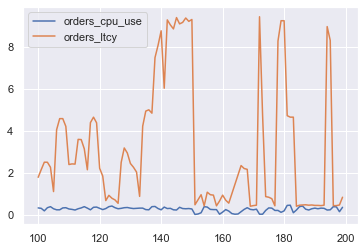

In [9]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [10]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

#rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
#sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

sfm = PCA(random_state=100)

# SVR
reg = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    
    #'selector__threshold': ['0.05*mean', '0.02*mean', '0.01*mean'] # with tree
    #, 'selector__estimator__max_depth' : [20]
    #, 'selector__estimator__n_estimators' : [40]
    
    'selector__n_components' : [10, 15, 20]   # with PCA
    ,'reg__C': [100]
    ,'reg__degree': [2]
    ,'reg__epsilon': [0.1]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [11]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 55.7min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=100,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('reg',
                                        SVR(C=100, cache_size=200, coef0=1,
                                            degree=3, epsilon=0.1, gamma='auto',
                                            kernel

# Best Model

In [12]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0551:
Best CV params = {'reg__C': 100, 'reg__degree': 2, 'reg__epsilon': 0.1, 'selector__n_components': 20}


# Features Selected

In [13]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

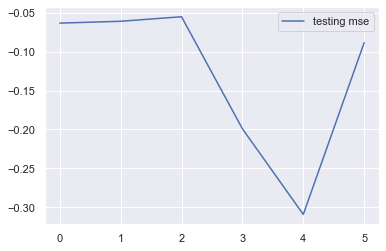

In [14]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [15]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.5771474178247618
Score (training) = -0.05007240099208566


In [16]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.36 (0.25) 0.00 1.33 MSE


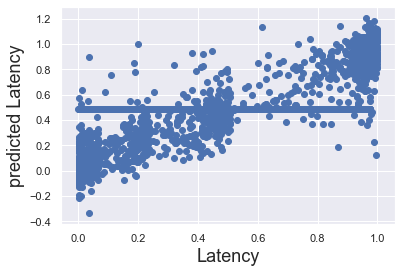

In [17]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

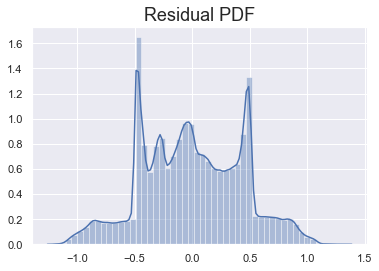

In [18]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [19]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

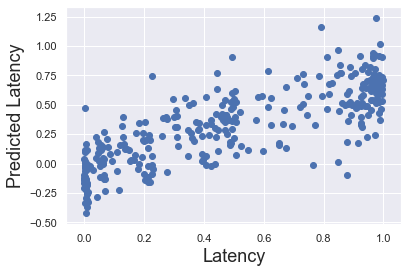

In [20]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

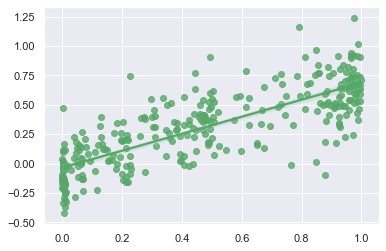

In [21]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [22]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,-0.1958,0.0016
1,-0.1430,0.0071
2,-0.0324,0.0093
3,0.0072,0.0027
4,-0.0649,0.0016


In [23]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,-0.1958,0.0016,-0.1973,"12,502.4488"
1,-0.1430,0.0071,-0.1501,"2,121.3861"
2,-0.0324,0.0093,-0.0416,448.8288
3,0.0072,0.0027,0.0045,169.1073
4,-0.0649,0.0016,-0.0665,"4,212.1265"
...,...,...,...,...
313,0.7333,0.9945,-0.2612,26.2669
314,0.5896,0.9967,-0.4071,40.8441
315,0.6343,0.9945,-0.3602,36.2219
316,0.4916,0.9384,-0.4468,47.6123


In [24]:
perf.describe()

,prediction,target,residual,difference%
count,318.0000,318.0000,318.0000,318.0000
mean,0.3131,0.4823,-0.1693,"1,052.1073"
std,0.3272,0.3622,0.2204,"4,273.3128"
min,-0.4198,0.0005,-0.9721,0.2634
25%,0.0383,0.1302,-0.3266,24.0718
50%,0.3297,0.4585,-0.1562,45.4880
75%,0.5572,0.8859,-0.0213,105.5412
max,1.2361,1.0000,0.5145,"43,715.1237"


In [25]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
215,0.20,0.20,0.00,0.26
306,0.92,0.92,-0.01,0.78
99,0.31,0.31,0.00,1.04
83,0.20,0.21,-0.00,1.11
135,0.84,0.85,-0.02,1.89
219,0.31,0.30,0.01,2.18
227,0.57,0.58,-0.01,2.36
190,0.73,0.71,0.02,2.45
295,0.94,0.96,-0.03,2.87
260,1.02,0.99,0.03,3.08


# *** Prediction Accuracy

In [26]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.4106756557827188


In [27]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.2776358540323697
